In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
#!git clone https://github.com/europeana/rd-img-classification-pilot.git

import sys
sys.path.append('../src')

import os
import json
import requests
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


from torch_utils import ResNet
from harvest_data import parse_CHO
from download_images import url2img
from gradcam import predict_grad_cam, plot_grad_cam


In [4]:
class EuropeanaAPI:
    
  def __init__(self,wskey):
    self.wskey = wskey

  def search(self,query,reusability='open',n=20):
    
    CHO_list = []
    
    params = {
        'reusability':reusability,
        'media':True,
        'qf':'TYPE:IMAGE', 
        'query':query, 
        'wskey':'api2demo'
    }
    
    response = {'nextCursor':'*'}
    while 'nextCursor' in response:
      params.update({'cursor':response['nextCursor']})
      response = requests.get('https://www.europeana.eu/api/v2/search.json', params = params).json()
      
      CHO_list += response['items']

      if len(CHO_list)>n:
        break

    return CHO_list[:n]

In [13]:
def load_model(root_path, device):
    checkpoint_path = os.path.join(root_path,'checkpoint.pth')

    model = ResNet(34,20)
    if not torch.cuda.is_available():
        model.load_state_dict(torch.load(checkpoint_path,map_location=torch.device('cpu')))
    else:
        model.load_state_dict(torch.load(checkpoint_path))

    model = model.to(device)
    model.eval()

    with open(os.path.join(root_path,'class_index.json'),'r') as f:
        class_index_dict = json.load(f)
        
    class_index_dict = {int(k):v for k,v in class_index_dict.items()}
        
    return model, class_index_dict
    
    

In [14]:
def predict(model,img,device):


    heatmap_layer = model.net.layer4[1].conv2
    image_interpretable,idx_pred,conf = predict_grad_cam(model, img, heatmap_layer, transform, device)
    return idx_pred,conf,image_interpretable

def plot_prediction(img,XAI_img):

    fig,ax = plt.subplots(1,2,figsize=(20,20))
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[1].imshow(XAI_img)
    ax[1].axis('off')
    plt.show()
    return 

In [15]:
root_path = '../model_zoo/3000'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model,class_index_dict = load_model(root_path, device)


In [16]:
class_index_dict

{0: 'archaeological_site',
 1: 'building',
 2: 'ceramics',
 3: 'clothing',
 4: 'costume_accessories',
 5: 'drawing',
 6: 'furniture',
 7: 'inscription',
 8: 'jewellery',
 9: 'map',
 10: 'painting',
 11: 'photograph',
 12: 'postcard',
 13: 'sculpture',
 14: 'specimen',
 15: 'tapestry',
 16: 'textile',
 17: 'toy',
 18: 'weaponry',
 19: 'woodwork'}

In [17]:
eu = EuropeanaAPI('api2demo')
CHO_list = eu.search('nature',reusability = 'open',n = 5)

URI:  http://data.europeana.eu/item/134/S_VGM_photo_1M16_A165001_6285


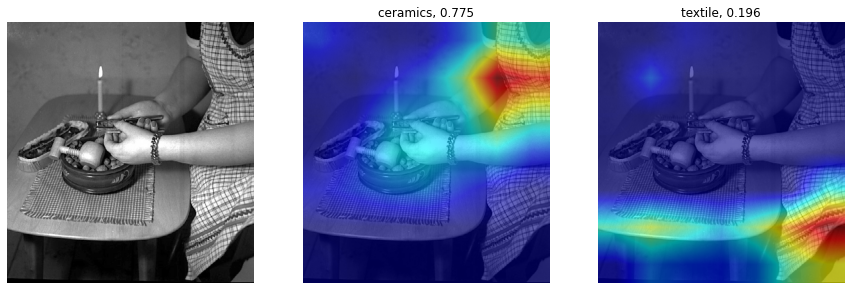

URI:  http://data.europeana.eu/item/2058611/_kimbl_9413a097_28dc_40b8_beb6_cb43f672effa


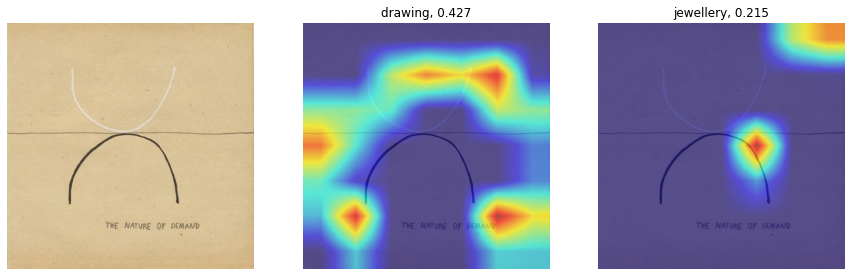

URI:  http://data.europeana.eu/item/125/contributions_b8a45c40_646b_0138_d91b_6eee0af52e33


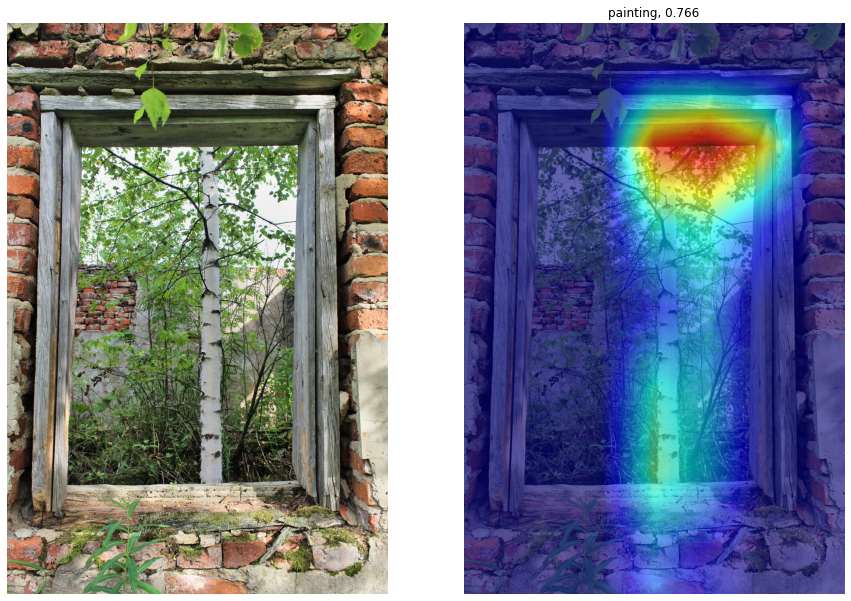

URI:  http://data.europeana.eu/item/463/item_V2UGYQS5STF4GTV26TVGMEDG4BXHZV3F


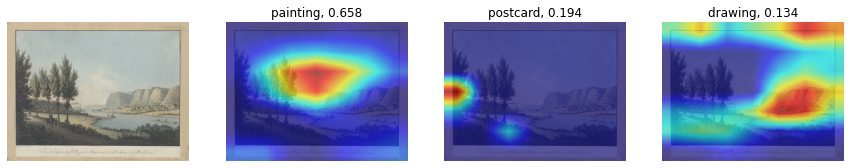

URI:  http://data.europeana.eu/item/463/item_YX54RBG7OZ3X3IJR2XQ37JMEY243HQCF


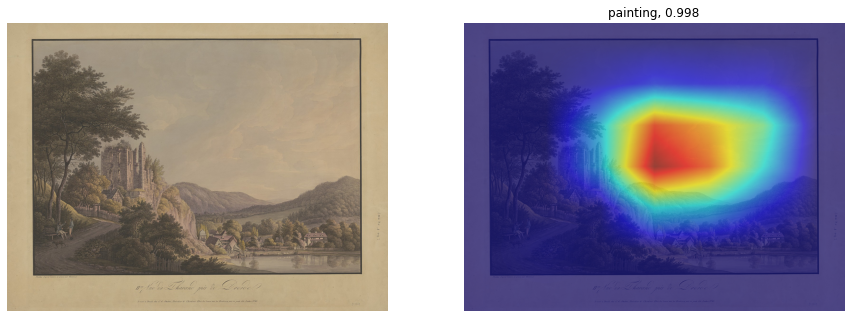

In [24]:

transform = transforms.Compose([
transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

for CHO in CHO_list:
    ID,URI,URL = parse_CHO(CHO)
    print('URI: ',URI)
    image = url2img(URL)
    if not image:
        continue
        
    category_list, confidence_list, XAI_list = predict_grad_cam(
        model = model, 
        class_index_dict = class_index_dict,
        image = image,
        heatmap_layer = model.net.layer4[1].conv2, 
        transform = transform, 
        device = device, 
        thres = 0.1, 
        max_pred = 5)
    
    plot_grad_cam(
        image = image,
        category_list = category_list, 
        confidence_list = confidence_list,
        XAI_list = XAI_list,
    )
    
    plt.show()
        
